In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

import SALib.analyze.morris
from SALib.sample import morris

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from tqdm import tqdm

from infrasim.optimise import *
from infrasim.utils import *

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['font.family']      = 'Arial'

In [2]:
def process_morris_results(problem,param_values,collected_results,num_levels):
    '''Process output from Morris sensitivitys
    '''
    Si = SALib.analyze.morris.analyze(problem,
                                      np.array(param_values),
                                      np.array(collected_results),
                                      print_to_console=False,
                                      num_levels=num_levels)

    sensitivity_results = pd.DataFrame.from_dict(Si)
    return sensitivity_results


def calculate_relative_influence(sensitivity_results):
    '''Return relative influence (%) of each parameter from sensitivity
    '''
    sensitivity = sensitivity_results.copy()
    sensitivity = sensitivity.fillna(0).reset_index(drop=True)
    sensitivity['rel'] = abs(sensitivity['mu'])/abs(sensitivity['mu']).sum()*100
    sensitivity['mu'] = sensitivity['mu']
    sensitivity = sensitivity[['names','rel']]
    sensitivity = sensitivity.sort_values(by='names',ascending=True).reset_index(drop=True)
    sensitivity.names = sensitivity.names.str.replace('_',' ')
    sensitivity.names = sensitivity.names.str.title()
    sensitivity.names = sensitivity.names.str.replace('Res','RES')
    sensitivity.names = sensitivity.names.str.replace('Coop','COO')
    sensitivity.names = sensitivity.names.str.replace('To','to')
    sensitivity.names = sensitivity.names.str.replace('Westbank','West Bank')
    return sensitivity


def read_results(path='../data/gsa_results/combined_capacities_271_generations.csv'):
    # read results
    combined_caps = pd.read_csv(path)
    # israel
    israel_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Israel'].fillna(0).to_list(),
                                            num_levels)
    # jordan
    jordan_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Jordan'].fillna(0).to_list(),
                                            num_levels)
    # west bank
    westbank_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['West Bank'].fillna(0).to_list(),
                                            num_levels)
    # gaza
    gaza_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Gaza'].fillna(0).to_list(),
                                            num_levels)
    # return
    return combined_caps,israel_results,jordan_results,westbank_results,gaza_results


def min_max_avg_plot(df,ax=None):
    # line plot
    sns.lineplot(x='value',y='variable',data=df,
                 linewidth=1,zorder=10,color='firebrick',ax=ax)
    # high and low
    sns.scatterplot(x='value',y='variable',data=df[df.stat != 'average'],
                    marker='|',s=100,color='firebrick',zorder=15,ax=ax)
    # mean
    sns.scatterplot(x='value',y='variable',data=df[df.stat == 'average'],
                    marker='o',s=100,color='firebrick',zorder=15,ax=ax)

In [3]:
# params
count       = 1
save_iter   = 25
timesteps   = None
num_levels  = 10
N           = 10

# Set up problem for sensitivity analysis # name:[lower_bound,upper_bound]
params = {'coop_res_target'                 : [0,0.5],
          'demand_factor'                   : [1,3],
          'solar_price_factor'              : [0.6,1.4],
          'wind_price_factor'               : [0.6,1.4],
          'self_sufficiency_factor'         : [0,1.0],
         }

# params = {'coop_res_target'                 : [0,0.8],
#           'jordan_to_westbank'              : [0,10**9],
#           'jordan_to_israel'                : [0,10**9],
#           'israel_to_westbank'              : [0,10**9],
#           'israel_to_jordan'                : [0,10**9],
#           'israel_to_gaza'                  : [0,10**9],
#           #'westbank_to_israel'              : [0,0], #[0,10**9],
#           'westbank_to_jordan'              : [0,10**9],
#           'self_sufficiency_factor'         : [0,1.0],
#          }

problem = {'num_vars'    : len(params.keys()),
           'names'       : [i for i in params.keys()],
           'bounds'      : [params[i] for i in params.keys()]
          }

# create parameter values
param_values = morris.sample(problem,N=N,
                             num_levels=num_levels,
                             local_optimization=True)

In [4]:
# Run analysis with the specified parameter values
collected_caps_israel   = []
collected_caps_jordan   = []
collected_caps_westbank = []
collected_caps_gaza     = []

#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'

for param_set in tqdm(param_values,total=len(param_values)):
    
    if round(param_set[1]) == 1:
        flows = '../data/nextra/nodal_flows/processed_flows_2030_low.csv'
    elif round(param_set[1]) == 2:
        flows = '../data/nextra/nodal_flows/processed_flows_2030_base.csv'
    elif round(param_set[1]) == 3:
        flows = '../data/nextra/nodal_flows/processed_flows_2030_high.csv'
    else:
        flows = '../data/nextra/nodal_flows/processed_flows_2030_base.csv'
    
    model_run = nextra(nodes,edges,flows,
                       timesteps=timesteps,
                       energy_objective=True,
                       scenario='COO',
                       super_sink=False,
                       super_source=False,
                       # params
                       coo_res_factor=round(param_set[0],2),
                       solar_price_factor=param_set[2],
                       wind_price_factor=param_set[3],
                       self_sufficiency_factor=param_set[4],
                      )
    
    # build, run, and get results
    model_run.build()
    model_run.run(pprint=False)
    try:
        model_results = model_run.get_results()
        # get capacities
        caps = model_results.results_capacities.copy()
        caps = caps.groupby(by='territory').max().reset_index()
        # append collected capacities
        collected_caps_israel.append(caps.loc[caps.territory == 'Israel','value'].values[0])
        collected_caps_jordan.append(caps.loc[caps.territory == 'Jordan','value'].values[0])
        collected_caps_westbank.append(caps.loc[caps.territory == 'West Bank','value'].values[0])
        collected_caps_gaza.append(caps.loc[caps.territory == 'Gaza','value'].values[0])
    except:
        collected_caps_israel.append(np.nan)
        collected_caps_jordan.append(np.nan)
        collected_caps_westbank.append(np.nan)
        collected_caps_gaza.append(np.nan)
    
    # make dataframes
    combined_caps = pd.DataFrame({'Israel' : collected_caps_israel,
                                  'Jordan' : collected_caps_jordan,
                                  'West Bank' : collected_caps_westbank,
                                  'Gaza' : collected_caps_gaza,})
    
    # save
    if count % save_iter == 0:
        combined_caps.to_csv('../data/gsa_results/combined_capacities_' 
                             + str(count) + '_generations.csv',index=False)
    
    # adjust counter
    count = count + 1
    
combined_caps.to_csv('../data/gsa_results/combined_capacities_' 
                             + str(count) + '_generations.csv',index=False)

  0%|                                                    | 0/60 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-03



  2%|▋                                        | 1/60 [03:44<3:41:10, 224.92s/it]

  3%|█▎                                       | 2/60 [07:34<3:39:58, 227.57s/it]

  5%|██                                       | 3/60 [09:52<2:57:17, 186.63s/it]

  7%|██▋                                      | 4/60 [12:03<2:33:47, 164.78s/it]

  8%|███▍                                     | 5/60 [14:14<2:20:01, 152.76s/it]

 10%|████                                     | 6/60 [16:12<2:06:46, 140.87s/it]

 12%|████▊                                    | 7/60 [18:51<2:09:37, 146.75s/it]

 13%|█████▍                                   | 8/60 [21:18<2:07:18, 146.90s/it]

 15%|██████▏                                  | 9/60 [24:26<2:15:42, 159.66s/it]

 17%|██████▋                                 | 10/60 [27:52<2:24:57, 173.94s/it]

 18%|███████▎                                | 11/60 [30:58<2:25:00, 177.56s/it]

 20%|████████                                | 12/60 [33:47<2:20:07, 175.15s/it]

 22%|████████▋                               | 13/60 [36:17<2:11:06, 167.36s/it]

 23%|█████████▎                              | 14/60 [38:42<2:03:08, 160.62s/it]

 25%|██████████                              | 15/60 [41:11<1:57:54, 157.20s/it]

 27%|██████████▋                             | 16/60 [43:48<1:55:14, 157.15s/it]

 28%|███████████▎                            | 17/60 [46:23<1:52:07, 156.44s/it]

 30%|████████████                            | 18/60 [50:07<2:03:43, 176.75s/it]

 32%|████████████▋                           | 19/60 [52:41<1:56:06, 169.90s/it]

 33%|█████████████▎                          | 20/60 [55:15<1:50:01, 165.05s/it]

 35%|█████████████▎                        | 21/60 [1:19:41<6:01:11, 555.67s/it]

 37%|█████████████▉                        | 22/60 [1:34:27<6:54:37, 654.67s/it]

 38%|██████████████▌                       | 23/60 [1:37:44<5:19:00, 517.32s/it]

 40%|███████████████▏                      | 24/60 [1:41:01<4:12:43, 421.19s/it]

 42%|███████████████▊                      | 25/60 [1:43:41<3:20:00, 342.86s/it]

 43%|████████████████▍                     | 26/60 [1:46:15<2:42:09, 286.15s/it]

 45%|█████████████████                     | 27/60 [1:48:56<2:16:50, 248.80s/it]

 47%|█████████████████▋                    | 28/60 [1:51:52<2:01:05, 227.03s/it]

 48%|██████████████████▎                   | 29/60 [1:54:44<1:48:44, 210.46s/it]

 50%|███████████████████                   | 30/60 [1:57:41<1:40:06, 200.21s/it]

 52%|███████████████████▋                  | 31/60 [2:01:24<1:40:10, 207.27s/it]

 53%|████████████████████▎                 | 32/60 [2:04:16<1:31:43, 196.55s/it]

 55%|████████████████████▉                 | 33/60 [2:07:12<1:25:38, 190.31s/it]

 57%|█████████████████████▌                | 34/60 [2:09:59<1:19:30, 183.47s/it]

 58%|██████████████████████▏               | 35/60 [2:12:49<1:14:44, 179.37s/it]

 60%|██████████████████████▊               | 36/60 [2:15:33<1:09:58, 174.95s/it]

 62%|███████████████████████▍              | 37/60 [2:18:18<1:05:52, 171.85s/it]

 63%|████████████████████████              | 38/60 [2:21:59<1:08:21, 186.44s/it]

 65%|████████████████████████▋             | 39/60 [2:25:37<1:08:39, 196.15s/it]

 67%|█████████████████████████▎            | 40/60 [2:29:48<1:10:50, 212.54s/it]

 68%|█████████████████████████▉            | 41/60 [2:32:32<1:02:42, 198.01s/it]

 70%|████████████████████████████            | 42/60 [2:35:15<56:13, 187.43s/it]

 72%|████████████████████████████▋           | 43/60 [2:38:16<52:30, 185.35s/it]

 73%|█████████████████████████████▎          | 44/60 [2:41:04<48:02, 180.17s/it]

 75%|██████████████████████████████          | 45/60 [2:43:35<42:55, 171.68s/it]

 77%|██████████████████████████████▋         | 46/60 [2:46:06<38:35, 165.38s/it]

 78%|███████████████████████████████▎        | 47/60 [2:48:35<34:44, 160.35s/it]

 80%|████████████████████████████████        | 48/60 [2:51:32<33:03, 165.33s/it]

 82%|████████████████████████████████▋       | 49/60 [2:54:49<32:04, 174.91s/it]

 83%|█████████████████████████████████▎      | 50/60 [2:57:46<29:15, 175.54s/it]

 85%|██████████████████████████████████      | 51/60 [3:01:18<27:58, 186.51s/it]

 87%|██████████████████████████████████▋     | 52/60 [3:04:43<25:37, 192.17s/it]

 88%|███████████████████████████████████▎    | 53/60 [3:07:24<21:19, 182.77s/it]

 90%|████████████████████████████████████    | 54/60 [3:10:19<18:02, 180.48s/it]

 92%|████████████████████████████████████▋   | 55/60 [3:12:57<14:27, 173.58s/it]

 93%|█████████████████████████████████████▎  | 56/60 [3:15:38<11:18, 169.72s/it]

 95%|██████████████████████████████████████  | 57/60 [3:19:18<09:14, 184.99s/it]

 97%|██████████████████████████████████████▋ | 58/60 [3:23:07<06:35, 197.98s/it]

 98%|███████████████████████████████████████▎| 59/60 [3:26:56<03:27, 207.46s/it]

100%|████████████████████████████████████████| 60/60 [3:30:21<00:00, 210.36s/it]


In [5]:
combined_caps.to_csv('../data/gsa_results/combined_capacities_' 
                             + str(count) + '_generations.csv',index=False)

combined_caps,israel_results,jordan_results,westbank_results,gaza_results = read_results(\
                path='../data/gsa_results/combined_capacities_' 
                             + str(count) + '_generations.csv')

collected_caps = combined_caps.copy()

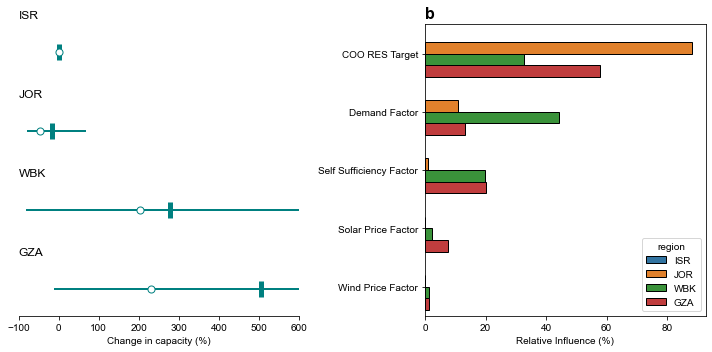

In [6]:
file = open('../outputs/results/model_run_results.pkl','rb')
results = pickle.load(file)
file.close()

baseline_caps = results['COO'].results_capacities.groupby(by='territory').max()['value'].to_dict()

for c in collected_caps.columns:
    collected_caps[c+'_influence'] = (collected_caps[c] - baseline_caps[c])/baseline_caps[c] * 100

collected_caps

isr = calculate_relative_influence(israel_results)
isr['region'] = 'ISR'

jor = calculate_relative_influence(jordan_results)
jor['region'] = 'JOR'

wbk = calculate_relative_influence(westbank_results)
wbk['region'] = 'WBK'

gza = calculate_relative_influence(gaza_results)
gza['region'] = 'GZA'

influence = isr.copy()
influence = influence.append(jor,ignore_index=True)
influence = influence.append(wbk,ignore_index=True)
influence = influence.append(gza,ignore_index=True)
influence['var'] = influence['names']

def custom_lineplot(df,colname,xlims,title,ax):
    x1 = df[colname].min()
    x2 = df[colname].max()
    x3 = df[colname].mean()
    x4 = df[colname].median()
    ax.plot([x1,x2],[0.5,0.5],linestyle='-',color='teal',linewidth=2,zorder=0)
    ax.scatter(x3,0.5,s=250,marker='|',color='teal',linewidth=5)
    ax.scatter(x4,0.5,s=50,marker='o',color='white',linewidth=1,edgecolor='teal')
    ax.set_xlim(xlims)
    ax.set_title(title,loc='left')
    
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(4,2,1)
ax2 = plt.subplot(4,2,3)
ax3 = plt.subplot(4,2,5)
ax4 = plt.subplot(4,2,7)
ax5 = plt.subplot(1,2,2)

xlims=[-100,600]

custom_lineplot(df=collected_caps,colname='Israel_influence',xlims=xlims,title='ISR',ax=ax1)
custom_lineplot(df=collected_caps,colname='Jordan_influence',xlims=xlims,title='JOR',ax=ax2)
custom_lineplot(df=collected_caps,colname='West Bank_influence',xlims=xlims,title='WBK',ax=ax3)
custom_lineplot(df=collected_caps,colname='Gaza_influence',xlims=xlims,title='GZA',ax=ax4)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.set_yticks([])

ax4.set_xlabel('Change in capacity (%)')

sns.barplot(x='rel',y='var',hue='region',data=influence,ax=ax5,edgecolor='black')
ax5.set_ylabel('')
ax5.set_xlabel('Relative Influence (%)')
ax5.set_title('b',loc='left',fontweight='bold',fontsize=16)

f.tight_layout() 
f.savefig('../outputs/figures/global_sensitivity.pdf',bbox_inches='tight')

In [7]:
israel_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Israel'].fillna(0).to_list(),
                                            num_levels)

israel_results

,names,mu,mu_star,sigma,mu_star_conf
0,coop_res_target,0.0,0.0,0.0,0.0
1,demand_factor,0.0,0.0,0.0,0.0
2,solar_price_factor,0.0,0.0,0.0,0.0
3,wind_price_factor,0.0,0.0,0.0,0.0
4,self_sufficiency_factor,0.0,0.0,0.0,0.0


In [8]:
collected_caps

isr = calculate_relative_influence(israel_results)
isr['region'] = 'ISR'

jor = calculate_relative_influence(jordan_results)
jor['region'] = 'JOR'

wbk = calculate_relative_influence(westbank_results)
wbk['region'] = 'WBK'

gza = calculate_relative_influence(gaza_results)
gza['region'] = 'GZA'

influence = isr.copy()
influence = influence.append(jor,ignore_index=True)
influence = influence.append(wbk,ignore_index=True)
influence = influence.append(gza,ignore_index=True)
influence['var'] = influence['names']